<a href="https://colab.research.google.com/github/ekaterina-kozh/SQL_EX/blob/main/35_%D1%83%D1%80%D0%BE%D0%BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Используя датасет MNIST Fashion (из набора датасетов Tensorflow) научить GAN генерировать образцы одежды, соответственно.



In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imageio
import cv2
from keras.preprocessing.image import img_to_array
import os
from keras import preprocessing
from keras.models import Sequential
from keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

Достаем датасет

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist

In [ ]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
print("x_train shape:", train_images.shape, "y_train shape:", train_labels.shape)

x_train shape: (60000, 28, 28) y_train shape: (60000,)


In [ ]:
# Нормализация данных
train_images = (train_images - 127.5) / 127.5
train_images = np.expand_dims(train_images, axis=-1)

In [ ]:
#Определние параметра
BUFFER_SIZE = 60000
BATCH_SIZE = 32
LATENT_DIM = 100
EPOCHS = 20

Сгенерируем датасет с разбивкой по батчам из тензора изображений NumPy.

In [ ]:
len(train_images) * 25.00 / 100.00

15000.0

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images[:15000]).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
len(train_dataset)

8

In [ ]:
# Создание генератора
def build_generator():
    model = Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(LATENT_DIM,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Reshape((7, 7, 256)))

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

generator = build_generator()

In [ ]:
# Создание дискиминатора
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Flatten())
    model.add(Dense(1))

    return model

discriminator = build_discriminator()

In [ ]:
# Определение функции потерь и оптимизатора
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
# Обучение модели
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [ ]:
import time
def train(dataset, epochs):
    D_loss=[] # список для сбора значений потерь для дискриминатора
    G_loss=[] # список для сбора значений потерь для генератора
    for epoch in range(epochs):
        start = time.time()
        print("\nЭпоха : {}".format(epoch + 1))
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)

        #if epoch % 100 == 0:
        print(" Время:{}".format(np.round(time.time() - start),2))
        print(f'Gen Loss: {gen_loss}, Disc Loss: {disc_loss}')
        D_loss.append(gen_loss)
        G_loss.append(disc_loss)
    return (G_loss, D_loss)

In [ ]:
G, D = train(train_dataset, EPOCHS)


Эпоха : 1
 Время:193.0
Gen Loss: 1.6520715951919556, Disc Loss: 0.9627412557601929

Эпоха : 2
 Время:190.0
Gen Loss: 1.2609418630599976, Disc Loss: 0.927436113357544

Эпоха : 3
 Время:189.0
Gen Loss: 1.574610710144043, Disc Loss: 0.8047070503234863

Эпоха : 4
 Время:189.0
Gen Loss: 1.2296769618988037, Disc Loss: 0.8046026229858398

Эпоха : 5
 Время:188.0
Gen Loss: 1.4074324369430542, Disc Loss: 0.9132677912712097

Эпоха : 6
 Время:188.0
Gen Loss: 1.763028621673584, Disc Loss: 0.8859432935714722

Эпоха : 7
 Время:188.0
Gen Loss: 1.3092511892318726, Disc Loss: 0.8068051338195801

Эпоха : 8
 Время:188.0
Gen Loss: 1.4470442533493042, Disc Loss: 0.7215454578399658

Эпоха : 9
 Время:188.0
Gen Loss: 1.4104998111724854, Disc Loss: 0.6830233335494995

Эпоха : 10
 Время:188.0
Gen Loss: 0.9598013758659363, Disc Loss: 0.9807801246643066

Эпоха : 11
 Время:188.0
Gen Loss: 1.1744924783706665, Disc Loss: 1.0643887519836426

Эпоха : 12
 Время:188.0
Gen Loss: 1.2447969913482666, Disc Loss: 1.048881053

In [ ]:
def plot_generated_images(square = 5):


  plt.figure(figsize = (10,10))
  for i in range(square * square):
    plt.subplot(square, square, i+1)
    noise = np.random.normal(0,1,(1,LATENT_DIM))
    img = generator(noise)
    plt.imshow(np.clip((img[0,...]+1)/2, 0, 1), cmap='gray')

    plt.axis('off')
    plt.grid()

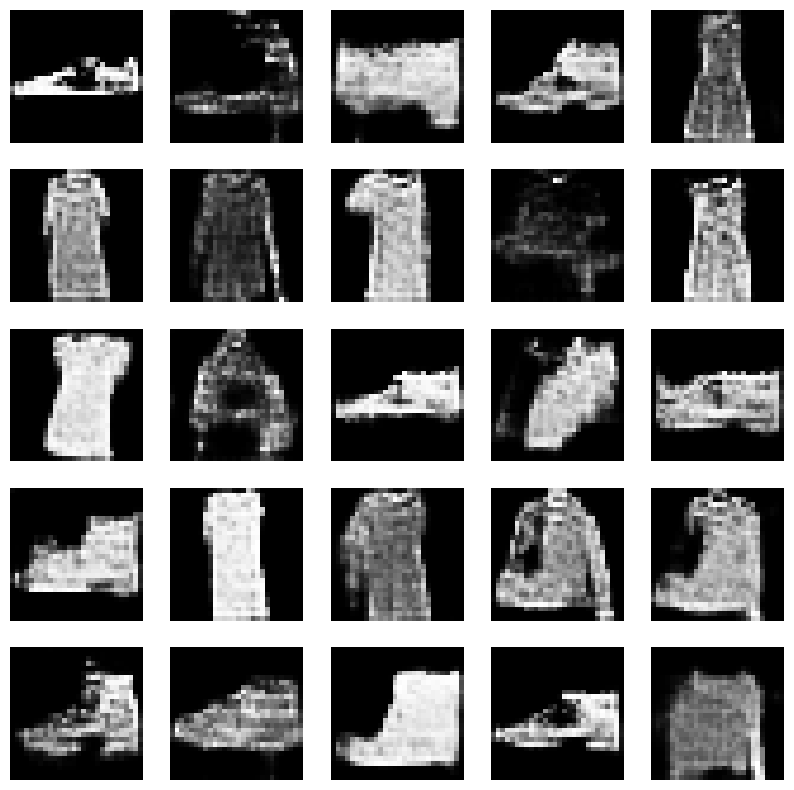

In [ ]:
plot_generated_images(5)

В результате 20 эпох обучения мы получили кто-то, похожее по очертаниям на одежду. Более точный результат можно получить, взяв в обработку больше данных и эпох обучения, но к сожалению, ОЗУ не даст нам этого сделать.

In [ ]:
def loss_plot(G, D):
    plt.figure(figsize=(10,10))
    plt.plot(G,color='red',label='Функция потерь на генераторе')
    plt.plot(D,color='blue',label='Функция потерь на дискриминаторе')
    plt.legend()
    plt.xlabel('Эпоха')
    plt.ylabel('Потери')
    plt.title('Функции потерь в конце обучения на эпохе')
    plt.show()

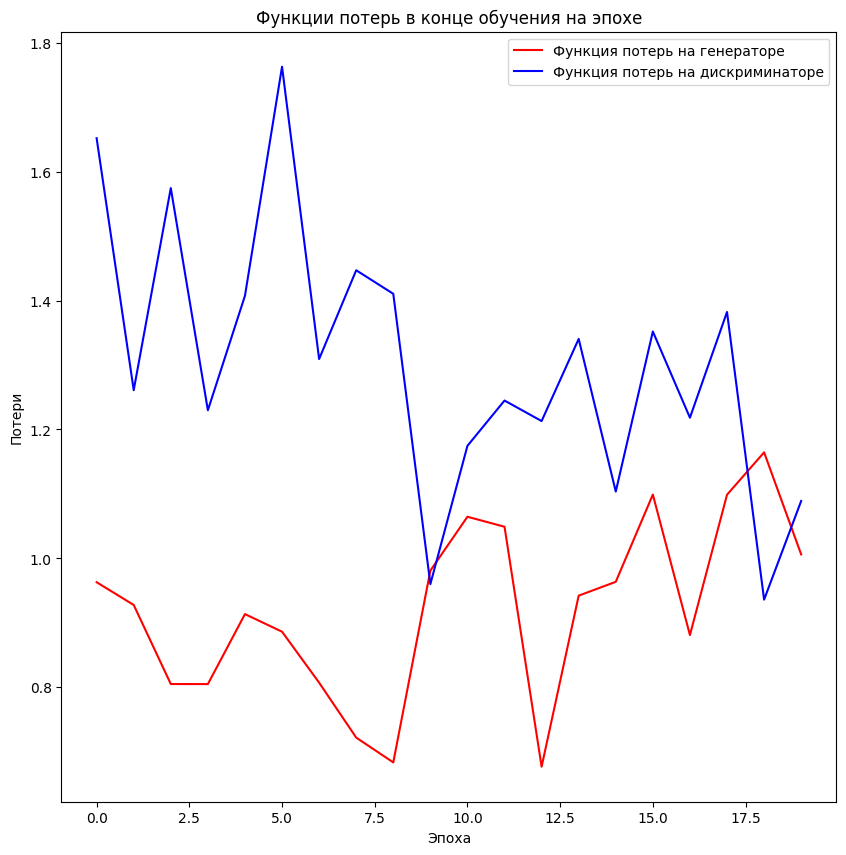

In [ ]:
loss_plot(G, D)